calibrate_main_equi2
m: 0.34871229269849163 +- 0.003963512587648744
b: -1.9100352035004426 +- 0.021789379881439294


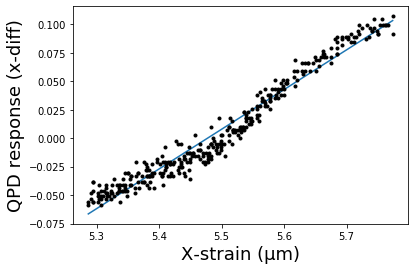

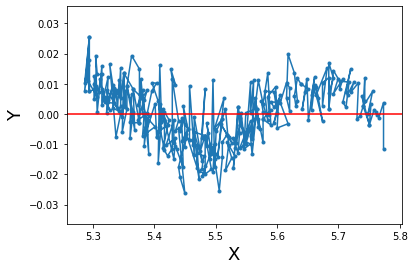

In [11]:
import numpy as np                                # import packages and give them quick handles since they will be used often
import matplotlib.pyplot as plt
from scipy import optimize                        # import a specific function from a package: 'optimize' for curve fitting

file_name = 'calibrate_main_equi2'                           # replace with the name of your csv data file

file_folder = ''                                  # use this if your data file is in the same folder as your python program

data_file = file_folder + file_name
print(data_file)


xdata, ydata  = np.loadtxt(                 
        data_file,                                # file to read
#        delimiter = '\t',                         # specify delimiting character 
       delimiter = ',',                           # specify delimiting character 
        skiprows = 5,                             # rows to skip for header
        usecols = (1, 2),                      # which columns to use
        unpack = True)                            # indicates that our data sets are in columns, not rows.                                                                                                   

def func(x,m,b):                                # Define your fitting function
    return m*x+b          

val = 340

xdata = xdata[:val]
ydata = ydata[:val]
 
initialguess = [1,1]                     # initial guess for the parameters of the function func

fit, covariance = optimize.curve_fit(             # call to the fitting routine curve_fit.  Returns optimal values of the fit parameters, and their estimated variance
        func,                                     # function to fit
        xdata,                                    # data for independant variable
        ydata,                                    # data for dependant variable
        initialguess)                             # initial guess of fit parameter

print("m:",fit[0],"+-",np.sqrt(covariance[0][0]))     #print value and one std error of the first fit parameter
print("b:",fit[1],"+-",np.sqrt(covariance[1][1]))     #print value and one std error of the second fit parameter
#print("Be sure to use the correct number of significant digits in your final answer!!!!!!!!!!!!1!")

slope = fit[0] 
intercept = fit[1]

##########
# Plotting data and fit
##########

xdatafit=np.linspace(min(xdata), max(xdata), 100) # make lots of xdata for a smooth curve
func_plot=func(xdatafit,*fit)                     # create discrete data set from fitting function

plt.clf()                                         # clear plot figure
plt.plot(xdatafit, func_plot)                     # plot the fit function 
plt.errorbar(xdata, ydata, fmt='k.')        # plot data with error bars, define format of plot (k=black)
#plt.title('Best Fit Linear Equation')             # plot title
plt.xlabel('X-strain (μm)',fontsize = 18)                     # label x axis
plt.ylabel('QPD response (x-diff)',fontsize = 18)                     # label y axis
#plt.xlim(np.min(xdata),np.max())             # choose limits of x or y axis 
#plt.ylim(np.min(ydata),np.max(5.8))             # choose limits of x or y axis                                          
plt.savefig("./"+file_name+'DataWithFit.pdf',dpi=300)         # save figure of plot
plt.show()                                        # show plot

##########
# Plotting residuals
##########

func_model=func(xdata,*fit)              # create discrete data set from fitting function
residual = (ydata-func_model)                  # create array of residual data

plt.clf()   
#plt.errorbar(xdata, residual, fmt='k.')
plt.scatter(xdata,residual, marker = ".", linestyle = "None")
plt.plot(xdata, residual)  
plt.axhline(y=0.0, color='r', linestyle='-') 
#plt.title('Residual')
plt.xlabel('X',fontsize = 18)
plt.ylabel('Y',fontsize = 18)
plt.savefig("./"+file_name+'Residual.pdf',dpi=300)         # save figure of plot
plt.show()




This calibration shows the relation between the QPD response $x_d$ (which is the data we have) and the strain guage $x_s$ (in micrometers, which is the data we NEED to use the equipartition method). y = mx + b becomes QPD = m(X_strain) + b, so we find:

$x_{strain} = x_s = (x_d - b)/m$

where we have m and b with their respective errors from the linear fit above.

We report m = 0.349(4) and b = -1.91(2).

Note that this was only for the x-axis, but it reasonably accounts for the y-axis as well, so we can use it for both. Now that we have calibrated, lets see the equipartition equation we're gonna use:

$k_bT = k_x(x_s)^2$

Insert our calibration,

$k_bT = k_x[\frac{(x_d-b)}{m}]^2$

rearrange for k_x (what we ultimately want, trap stiffness),

$k_x = k_bT[\frac{m}{x_d-b}]^2$

Now dealing with uncertainties. Uncert on $k_x$ is a function of the uncert of its components, so $k_b$ (known precisely, boltzmann is awesome.), $T$ (little value in error of room temp), and $m, b, x_d.$ Error on $m,b$ are given from linear regression, so we find uncert on $x_d$, or justify its exclusion.

Without diving too deep into the mechanics of strain gauges, it seems a general consensus is that the uncert usually lies in manufacturing limits (generally around 1%) and linearity (which we have accounted for by calibrating). However, since each of uncerts will be very similar (uncertainty of b of 0.02 is already approx. the scale of the $x_s$ data), I take it to be constant to make life much easier for everyone. We will get uncertainty from the linear fitting of the points and everyone will be happy and healthy.

Another point before moving on is that $x_d$ will be calculated using pythagorean theorem combining x_diff and y_diff data per point, to find a total displacement from the center. To normalize using sum, we divide by SUM at each data point. This will treat the raw data and let us start averaging each current's average k value.

In [4]:
file_name = 'equi_249.7'                           # replace with the name of your csv data file

file_folder = ''                                  # use this if your data file is in the same folder as your python program

data_file = file_folder + file_name
#print(data_file)


xdiff, ydiff, sumdata  = np.loadtxt(                 
        data_file,                                # file to read
#        delimiter = '\t',                         # specify delimiting character 
       delimiter = ',',                           # specify delimiting character 
        skiprows = 5,                             # rows to skip for header
        usecols = (1, 2, 3),                      # which columns to use
        unpack = True)                            # indicates that our data sets are in columns, not rows. 

m = slope                                   #from above
b = intercept                           #from above 
boltzmann = 8.617333262e-5 * 1.602e-19          #in Joules per Kelvin
T = 298                                         #standard room temp in Kelvin

print(slope,intercept,boltzmann,T)
   
for i in range(len(xdiff)):
    xdiff[i] = boltzmann*T*(m/(xdiff[i]-b))**2
    ydiff[i] = boltzmann*T*(m/(ydiff[i]-b))**2
    sumdata[i] = boltzmann*T*(m/(sumdata[i]-b))**2




diff_total = []
print(len(xdiff), len(ydiff), len(sumdata))
for k in range(len(xdiff)):
    diff_total.append(np.sqrt(xdiff[k]**2+ydiff[k]**2)/sumdata[k])
    #diff_total.append(np.sqrt(xdiff[k]**2+ydiff[k]**2))
print(np.average(diff_total))

currents = []
averages = []

averages.append(np.average(diff_total))
currents.append(float(file_name.split('_')[1]))

print(currents,averages)

print(np.std(diff_total))

0.34871229269849163 -1.9100352035004426 1.3804967885724e-23 298
1000 1000 1000
16.77447611637971
[249.7] [16.77447611637971]
0.510045077494117


There we have, for 249.7mA, we have a k value of 16.8(5) Newtons/micrometer. We can get uncertainty from the standard deviation of the distribution of the data, which was done above.

Cool, looks reasonable (?). Lets automate the other lower current data!

In [6]:
filenames = [249.7,200,180.3,159.8,140,126.7,120,100,90,85,80]
currents = []
averages = []
uncerts = []

for i in filenames:
    file_name = 'equi_' + str(i)                           # replace with the name of your csv data file
    file_folder = ''                                  # use this if your data file is in the same folder as your python program
    data_file = file_folder + file_name
    print(data_file)
    
    xdiff, ydiff, sumdata  = np.loadtxt(                 
        data_file,                                # file to read
        delimiter = ',',                           # specify delimiting character 
        skiprows = 5,                             # rows to skip for header
        usecols = (1, 2, 3),                      # which columns to use
        unpack = True)                            # indicates that our data sets are in columns, not rows. 

    
    #print('hi')


    m = slope                                   #from above
    b = intercept                           #from above 
    boltzmann = 8.617333262e-5 * 1.602e-19          #in Joules per Kelvin
    T = 298                                         #standard room temp in Kelvin

    #print(slope,intercept,boltzmann,T)
    #print(currents,averages)


    for j in range(len(xdiff)):
        xdiff[j] = boltzmann*T*(m/(xdiff[j]-b))**2
        ydiff[j] = boltzmann*T*(m/(ydiff[j]-b))**2
        sumdata[j] = boltzmann*T*(m/(sumdata[j]-b))**2

    
    #print(xdiff)
    
    diff_total = []
    #print(len(xdiff), len(ydiff), len(sumdata))
    for k in range(len(xdiff)):
        diff_total.append(np.sqrt(xdiff[k]**2+ydiff[k]**2)/sumdata[k])
        #diff_total.append(np.sqrt(xdiff[k]**2+ydiff[k]**2))
    
    uncert = np.std(diff_total)
    
    uncerts.append(uncert)
    averages.append(np.average(diff_total))
    currents.append(float(file_name.split('_')[1]))
    

#print(currents,averages)
#print(uncerts)


equi_249.7
equi_200
equi_180.3
equi_159.8
equi_140
equi_126.7
equi_120
equi_100
equi_90
equi_85
equi_80
[0.510045077494117, 0.35614766885396715, 0.25057133876802934, 0.1782562601876343, 0.13104198764852337, 0.05922709518449909, 0.08314591483890407, 0.03996798150947773, 0.029150809523349495, 0.026268377855444888, 0.042035794757064926]


m: 0.07200257849826061 +- 0.0060231068226771056
b: -4.314830500670146 +- 0.5734087618563998


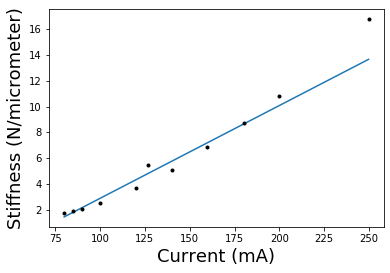

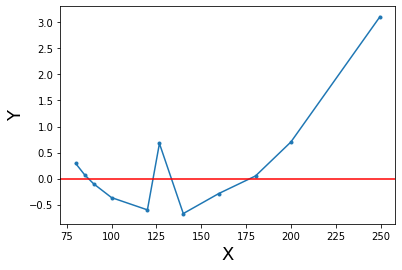

In [8]:
xdata = np.array(currents)
ydata = np.array(averages)
yerr = np.array(uncerts)

def func(x,m,b):                                # Define your fitting function
    return m*x+b          

initialguess = [1,1]                     # initial guess for the parameters of the function func

fit, covariance = optimize.curve_fit(             # call to the fitting routine curve_fit.  Returns optimal values of the fit parameters, and their estimated variance
        func,                                     # function to fit
        xdata,                                    # data for independant variable
        ydata,                                    # data for dependant variable
        initialguess,
        yerr)                             # initial guess of fit parameter

print("m:",fit[0],"+-",np.sqrt(covariance[0][0]))     #print value and one std error of the first fit parameter
print("b:",fit[1],"+-",np.sqrt(covariance[1][1]))     #print value and one std error of the second fit parameter
#print("Be sure to use the correct number of significant digits in your final answer!!!!!!!!!!!!1!")

##########
# Plotting data and fit
##########

xdatafit=np.linspace(min(xdata), max(xdata), 100) # make lots of xdata for a smooth curve
func_plot=func(xdatafit,*fit)                     # create discrete data set from fitting function

plt.clf()                                         # clear plot figure
plt.plot(xdatafit, func_plot)                     # plot the fit function 
plt.errorbar(xdata, ydata, fmt='k.')        # plot data with error bars, define format of plot (k=black)
#plt.title('Best Fit Linear Equation')             # plot title
plt.xlabel('Current (mA)',fontsize = 18)                     # label x axis
plt.ylabel('Stiffness (N/micrometer)',fontsize = 18)                     # label y axis
#plt.xlim(np.min(xdata),np.max())             # choose limits of x or y axis 
#plt.ylim(np.min(ydata),np.max(5.8))             # choose limits of x or y axis                                          
plt.savefig("./"+file_name+'DataWithFit.pdf',dpi=300)         # save figure of plot
plt.show()                                        # show plot

##########
# Plotting residuals
##########

func_model=func(xdata,*fit)              # create discrete data set from fitting function
residual = (ydata-func_model)                  # create array of residual data

plt.clf()   
#plt.errorbar(xdata, residual, fmt='k.')
plt.scatter(xdata,residual, marker = ".", linestyle = "None")
plt.plot(xdata, residual)  
plt.axhline(y=0.0, color='r', linestyle='-') 
#plt.title('Residual')
plt.xlabel('X',fontsize = 18)
plt.ylabel('Y',fontsize = 18)
plt.savefig("./"+file_name+'Residual.pdf',dpi=300)         # save figure of plot
plt.show()


Now if you ask me, thats a decent line. So the end result is that stiffness is linearly positively related to current, and it can be described in the function:

$k = 0.072(6)\times I - 4.3(6)$ N/μm

with units of N/$\mu$ per mA